# **Home Assignment 1**
**Objective:** Implement and analyze different generative models for image generation and translation.  

## **General Instructions**  
✅ **Code Implementation:**  
- Write code in the specified notebook cells.  
- Use **built-in methods** from libraries (e.g., `sklearn`, `PyTorch`) instead of reinventing the wheel.  
- Ensure reproducibility by fixing random seeds (e.g., `random_state=42`).  

📝 **Discussion & Reporting:**  
- Add a **Markdown cell** after each task to discuss results (if required).  
- Keep explanations concise.  

⚠ **Grading Policy**  
- **All-or-nothing scoring** – Full points or zero for each subtask (no partial credit).  
- **Mandatory reproducibility** – Reviewers must obtain identical results when rerunning your notebook.  
- **Output preservation required** – TAs will not rerun notebooks unless potential fraud is detected.  

🔍 **Allowed Resources:**  
- Official docs: [Python](https://docs.python.org/3/), [NumPy](https://numpy.org/doc/), [Matplotlib](https://matplotlib.org/), [scikit-learn](https://scikit-learn.org/stable/).  
- External help: Lecture slides, seminars, Google, StackOverflow.  

---

### **Final Checklist**  
✔ All code is **well-commented** and reproducible.  
✔ Discussions are included where required.  
✔ Notebook runs **end-to-end without errors**.  

**Tip:** Use section headers (like above) in your notebook to improve readability.  

---

# **Part 1: VAEs with Non-Gaussian Decoders (20 points)**  

To begin with, let's import the essential (for this assignment) libraries.

In [1]:
import random
from functools import partial
from itertools import chain
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.distributions import Bernoulli, Categorical, Independent, Normal
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

In [3]:
# Fix PyTorch seeds
torch.manual_seed(42)  # CPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)  # GPU

# Fix NumPy seed
np.random.seed(42)

# Fix Python's built-in random seed
random.seed(42)

## Task 1: VAE with Bernoulli Decoder (15 pts)
**Objective**: Implement a VAE where the decoder models pixel values as **Bernoulli-distributed** and examine its properties.

### Distribution Choice
In **Seminar 2**, we assumed a *Gaussian* decoder:  
$$
{\color{blue}p_\theta}(x|z) = \mathcal{N}(x \mid {\color{blue}\mu_\theta}(z), \sigma^2) \quad \text{(for continuous data)}.  
$$  

For **MNIST** (binary-like pixels), a **Bernoulli decoder** is more appropriate:  
- Each pixel is binary: `0` (black) or `1` (white).  
- The decoder outputs **logits** (unbounded values), which are transformed into probabilities $p_i \in [0,1]$ via the sigmoid function.  
- Likelihood:  
$$
{\color{blue}p_\theta}(x|z) = \prod_{i=1}^D \left( {\color{blue}p_\theta}(z)_i^{x_i} (1 - {\color{blue}p_\theta}(z)_i)^{1-x_i} \right),  
$$  
where $D = \text{image dimensions (e.g., } 28 \times 28)$.  

**Note**: The decoder returns **logits**, which are transformed into probabilities (you need to understand in which way) for the Bernoulli likelihood.

### 1.1 Data Preparation

We download MNIST data for this experiment and divide it into train and test subsets.

In [4]:
# transform
transform = transforms.Compose([transforms.ToTensor()])

# train dataset
train_dataset = torchvision.datasets.MNIST(root=".", train=True, download=True, transform=transform)

# Test dataset
test_dataset = torchvision.datasets.MNIST(root=".", train=False, transform=transform)

### 1.2 Encoder and Decoder Architecture (2 points)

Initialize networks for the encoder and decoder. Choose dimensions for latent and data spaces, then implement appropriate architectures for both.

In [ ]:
# YOU CODE HERE

LATENT_DIM = ...  # dimension of latent space
HIDDEN_DIM = ...  # dimensions of intermediate representations.
DATA_DIM = ...  # dimension of data space

In [ ]:
class Encoder(nn.Module):
    def __init__(self, data_dim: int = DATA_DIM, hidden_dim: int = HIDDEN_DIM, latent_dim: int = LATENT_DIM):
        super(Encoder, self).__init__()
        self.mean_net = nn.Sequential(
            # YOU CODE HERE
        )
        self.log_var_net = nn.Sequential(
            # YOU CODE HERE
        )

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # YOU CODE HERE

In [ ]:
class BernoulliDecoder(nn.Module):
    def __init__(self, data_dim: int = DATA_DIM, latent_dim: int = LATENT_DIM, hidden_dim: int = HIDDEN_DIM):
        super(BernoulliDecoder, self).__init__()
        self.net = nn.Sequential(
            # YOU CODE HERE
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        # YOU CODE HERE
        return ... # outputs logits for Bernoulli distribution

### 1.3 Loss Helpers (2 points)

Implement helper functions for the VAE loss. Review the loss function structure below to understand each component's purpose.

In [ ]:
def preprocess_x_bernoulli(x: torch.Tensor) -> torch.Tensor:
    """
    Preprocess input tensor for a Bernoulli decoder by binarizing values.

    Args:
        x: Input tensor with values in [0, 1]

    Returns:
        Binarized tensor (values 0 or 1)
    """
    return ... # YOU CODE HERE

In [ ]:
def px_z_bernoulli(logits: torch.Tensor) -> torch.distributions.Distribution:
    """
    Define the likelihood distribution p(x|z) using a Bernoulli distribution.

    Args:
        logits: Output from the decoder representing Bernoulli logits

    Returns:
        A Bernoulli distribution with independent dimensions
    """
    return ... # YOU CODE HERE

The function below will be used for data *visualization*, but not in loss function.

In [ ]:
def logits_to_pixels_bernoulli(logits: torch.Tensor) -> torch.Tensor:
    """
    Convert decoder logits to pixel values of the most probable class from the Bernoulli distribution.
    
    Args:
        logits: Unbounded output tensor from the decoder network
               Shape: [batch_size, data_dim]
               
    Returns:
        Tensor of pixel probabilities in range [0, 1] with same shape as input
    """
    return ... # YOU CODE HERE

### 1.4 VAE Loss function (5 points)

Implement general-purpose loss function for the VAE that will later be used also for more general Categorical Decoder.

In [ ]:
def loss_vae(
    x: torch.Tensor,
    encoder: nn.Module,
    decoder: nn.Module,
    preprocess_x: Callable[[torch.Tensor], torch.Tensor],
    px_z: Callable[[torch.Tensor], torch.distributions.Distribution],
    latent_dim: int = LATENT_DIM,
    device: torch.device = DEVICE,
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Compute the VAE loss (negative ELBO) and decoder output for a minibatch.

    Args:
        x: Input tensor of shape (batch_size, ...)
        encoder: Encoder network that outputs tuple (mu, log_var)
        decoder: Decoder network that takes latent vector and returns logits
        preprocess_x: Function to preprocess x before computing likelihood
        px_z: Function that returns a likelihood distribution p(x|z)
        latent_dim: Dimension of latent space
        device: Target device (cuda/cpu)

    Returns:
        Tuple containing:
        - Total VAE loss (scalar tensor)
        - Decoder output tensor (logits)
    """
    batch_size = x.size(0)

    # Encoder outputs parameters for q(z|x)
    ... # YOU CODE HERE
    
    # Prior p(z) ~ N(0, I)
    pz = Independent(
        Normal(
            loc=torch.zeros(batch_size, latent_dim, device=device),
            scale=torch.ones(batch_size, latent_dim, device=device),
        ),
        reinterpreted_batch_ndims=1,
    )

    # Posterior q(z|x) ~ N(mu_z, diag(exp(log_var_z)))
    qz_x = Independent(
        Normal(...) # YOU CODE HERE
        reinterpreted_batch_ndims=1,
    )

    # Reparameterization trick to sample z
    z = ... # YOU CODE HERE

    # Decode to get logits for p(x|z)
    decoder_output = ... # YOU CODE HERE

    # Preprocess input and compute reconstruction loss
    x_target = preprocess_x(x)
    recon_loss = -px_z(decoder_output).log_prob(x_target).mean()

    # KL divergence between q(z|x) and p(z)
    kl_div = ... # YOU CODE HERE

    # Total loss = reconstruction + KL divergence
    loss = recon_loss + kl_div

    return loss, decoder_output

In [12]:
loss_vae_bernoulli = partial(
    loss_vae,
    preprocess_x=preprocess_x_bernoulli,
    px_z=px_z_bernoulli
)

### 1.5 Training and Selecting Hyperparameters (1 point)

Fill gaps in training function and select hyperparameters for training.

In [ ]:
def train_model(
    loss_fn: Callable[[torch.Tensor, nn.Module, nn.Module], tuple[torch.Tensor, torch.Tensor]],
    encoder: nn.Module,
    decoder: nn.Module,
    train_dataset: torch.utils.data.Dataset,
    test_dataset: torch.utils.data.Dataset,
    batch_size: int,
    num_epochs: int,
    learning_rate: float,
    data_dim: int = DATA_DIM,
    device: torch.device = DEVICE,
    print_freq: int = 10,
) -> tuple[list[float], list[float]]:
    """
    Train a VAE model with tqdm progress monitoring.
    
    Args:
        loss_fn: Function that computes (loss, reconstruction)
        encoder: VAE encoder network
        decoder: VAE decoder network
        train_dataset: Training dataset
        test_dataset: Validation dataset
        batch_size: Size of mini-batches
        num_epochs: Number of training epochs
        learning_rate: Adam optimizer learning rate
        latent_dim: Dimension of data space
        device: Target device (cuda/cpu)
        print_freq: Batch frequency for logging
        
    Returns:
        Tuple of (train_loss_history, val_loss_history)
    """
    # Initialize optimizer
    optimizer = optim.Adam(
        chain(encoder.parameters(), decoder.parameters()),
        lr=learning_rate
    )
    
    train_losses = []
    val_losses = []
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Main training loop with tqdm
    encoder.to(device)
    decoder.to(device)
    for epoch in tqdm(range(num_epochs), desc="Epochs", unit="epoch"):
        encoder.train()
        decoder.train()
        
        # Batch progress bar
        batch_loop = tqdm(train_loader, leave=False, desc=f"Epoch {epoch+1}")
        for batch_idx, (batch, _) in enumerate(batch_loop):
            batch = batch.view(-1, data_dim).to(device)
            
            # Forward/backward pass
            ... # YOU CODE HERE
            
            # Logging
            train_losses.append(loss.item())
            if (batch_idx + 1) % print_freq == 0:
                batch_loop.set_postfix(loss=f"{loss.item():.4f}")
        
        # Validation phase
        encoder.eval()
        decoder.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch, _ in test_loader:
                batch = batch.view(-1, data_dim).to(device)
                loss, _ = loss_fn(batch, encoder, decoder)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update epoch progress
        tqdm.write(f"Epoch {epoch+1} - Train Loss: {train_losses[-1]:.4f} | Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

In [ ]:
# Choose appropriate hyperparameters

BATCH_SIZE = ...  # YOU CODE HERE
NUM_EPOCHS = ...  # YOU CODE HERE
LR = ...  # YOU CODE HERE

In [ ]:
encoder_bernoulli = # YOU CODE HERE
decoder_bernoulli = # YOU CODE HERE

In [16]:
train_losses, val_losses = train_model(
    loss_fn=loss_vae_bernoulli,
    encoder=encoder_bernoulli,
    decoder=decoder_bernoulli,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    learning_rate=LR,
)

Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1 - Train Loss: 151.5267 | Val Loss: 143.1011


Epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2 - Train Loss: 123.1636 | Val Loss: 119.5631


Epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3 - Train Loss: 112.1918 | Val Loss: 108.5119


Epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4 - Train Loss: 99.1043 | Val Loss: 103.4858


Epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5 - Train Loss: 99.9836 | Val Loss: 100.0500


Epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 6 - Train Loss: 100.6814 | Val Loss: 98.3454


Epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 7 - Train Loss: 91.8171 | Val Loss: 96.4233


Epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 8 - Train Loss: 96.2969 | Val Loss: 95.1793


Epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 9 - Train Loss: 93.0117 | Val Loss: 94.5150


Epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 10 - Train Loss: 91.6308 | Val Loss: 93.7132


### 1.6 VAE Inference (1 point)

Implement code to:
1. Sample latent codes ${\color{purple}p_Z}(z)$
2. Generate images via decoder ${\color{blue}p_\theta}(x|z)$

Visualization function is provided. Output should match:
![VAE samples](https://i124.fastpic.org/big/2024/1113/d7/286de6a255bed7ad26f56bf0d97b5cd7.png)

In [ ]:
def generate_vae_samples(
    decoder: nn.Module,
    logits_to_pixels: Callable[[torch.Tensor], torch.Tensor],
    n_samples: int = 50,
    latent_dim: int = LATENT_DIM,
    device: torch.device = DEVICE,
    img_shape: tuple[int, int] = (28, 28),
) -> np.ndarray:
    """
    Generate samples via a trained VAE decoder.

    Args:
        decoder: Trained decoder network (pθ(x|z)) that outputs logits
        logits_to_pixels: Function converting output of decoder to pixel probabilities
        n_samples: Number of samples to generate
        latent_dim: Dimension of latent space
        device: Computation device
        img_shape: Target image shape (H, W)

    Returns:
        Generated samples as numpy array of shape (n_samples, H, W)
        with integer values in [0, num_categories - 1]
    """
    height, width = img_shape
    
    with torch.no_grad():
        # Sample z ~ N(0, I)
        prior_dist = Independent(
            Normal(loc=torch.zeros(n_samples, latent_dim, device=device),
                   scale=torch.ones(n_samples, latent_dim, device=device)),
            reinterpreted_batch_ndims=1,
        )
        latent_vectors = prior_dist.sample()

        logits = ... # YOU CODE HERE

        images = ... # YOU CODE HERE

        # Reshape to image format
        samples = images.view(n_samples, height, width).cpu().numpy()

    return samples

Below we provide a function to visualize samples.

In [18]:
def visualize_samples(samples: np.ndarray, n_rows: int = 5, n_cols: int = 10, figsize_scale: float = 1.4) -> None:
    """
    Visualize generated samples in a grid layout.

    Args:
        samples: Array of samples with shape (n_samples, height, width)
        n_rows: Number of rows in grid
        n_cols: Number of columns in grid
        figsize_scale: Scaling factor for figure size
    """
    # Create subplot grid
    _, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(int(figsize_scale * n_cols), int(figsize_scale * n_rows)),
        subplot_kw={"xticks": [], "yticks": []},
    )

    # Plot each sample in the grid
    for idx, ax in enumerate(axes.flat):
        if idx < len(samples):  # Only plot if sample exists
            ax.imshow(samples[idx], cmap="gray", vmin=0, vmax=1)

    plt.tight_layout()

Now we pass the trained decoder to visualize the samples.

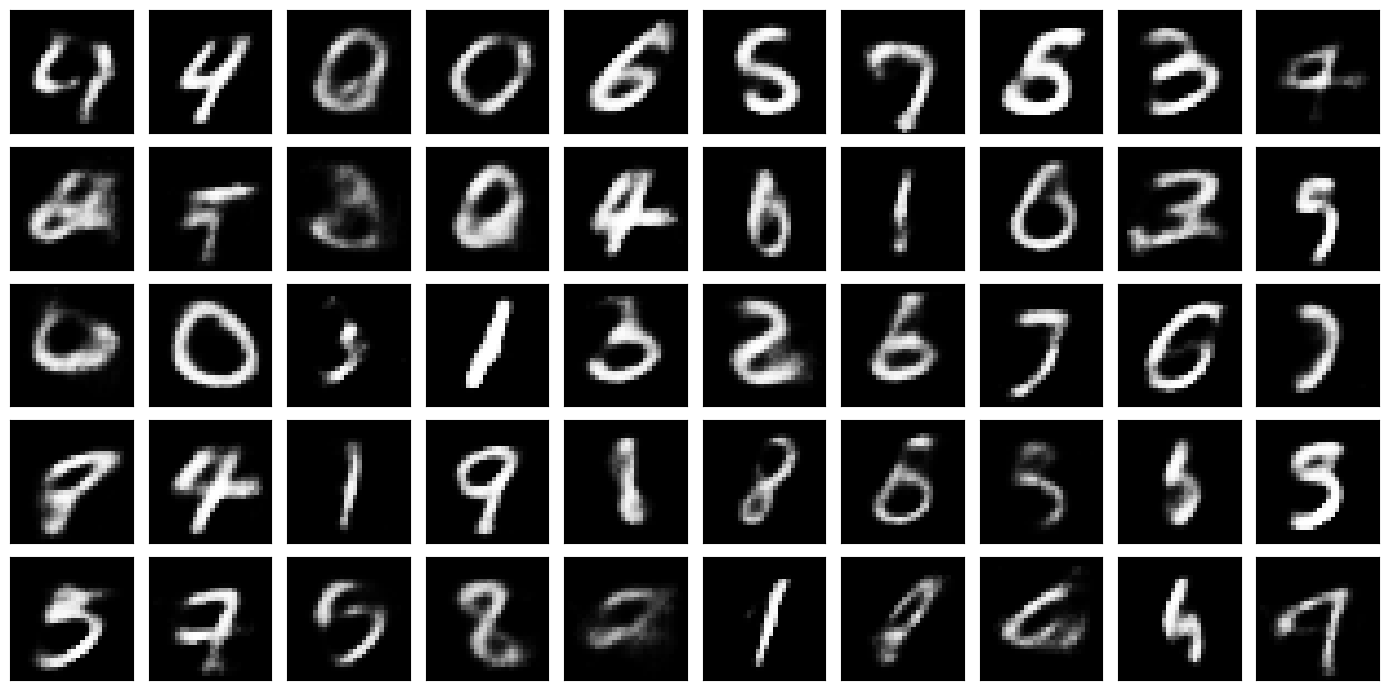

In [19]:
visualize_samples(generate_vae_samples(decoder=decoder_bernoulli, logits_to_pixels=logits_to_pixels_bernoulli))

### 1.7 Model Evaluation Task (2 points)

You have generated images from your model. To evaluate their quality, please perform the following comparison:

1. **Data Preparation**:
   - Generate 5,000 images using your trained model
   - Select 5,000 real images from the original dataset

2. **Classification Setup**:
   - Label generated images as `0` (fake)
   - Label real images as `1` (real)
   - Combine into a single dataset (10,000 total samples)

3. **Classifier Training**:
   - Train an MLP classifier using scikit-learn's `MLPClassifier`

4. **Evaluation**:
   - Calculate ROC-AUC score:

5. **Analysis**:
   - Report the ROC-AUC score
   - Document your observations about:
     - How distinguishable the generated images are from real ones
     - The implications for your VAE's performance

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Constants
NUM_SAMPLES = ... # YOU CODE HERE
TEST_SIZE = ... # YOU CODE HERE

In [ ]:
def prepare_dataset(
    decoder: nn.Module,
    logits_to_pixels: Callable[[torch.Tensor], torch.Tensor],
    dataset: torch.utils.data.Dataset,
    num_samples: int = NUM_SAMPLES,
) -> tuple[np.ndarray, np.ndarray]:
    """Prepare real and generated samples with labels."""
    # Generate fake samples
    fake_samples = ... # YOU CODE HERE

    # Get real samples
    real_samples, _ = # YOU CODE HERE

    # Combine and label
    data = np.concatenate(
        [real_samples.squeeze(1).cpu().numpy().reshape(num_samples, -1), fake_samples.reshape(num_samples, -1)]
    )
    labels = np.concatenate([np.ones(num_samples), np.zeros(num_samples)])

    return MinMaxScaler().fit_transform(data), labels

In [ ]:
def train_discriminator(X: np.ndarray, y: np.ndarray) -> MLPClassifier:
    """Train MLP classifier to distinguish real vs generated samples."""
    mlp = ... # YOU CODE HERE
    return mlp.fit(X, y)

In [ ]:
def evaluate_model(model: MLPClassifier, X: np.ndarray, y: np.ndarray) -> float:
    """Evaluate model and plot ROC curve."""
    y_proba = ... # YOU CODE HERE
    roc_auc = ... # YOU CODE HERE

    # Plotting
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Real vs Generated Image Classification")
    plt.legend()
    plt.show()

    return roc_auc

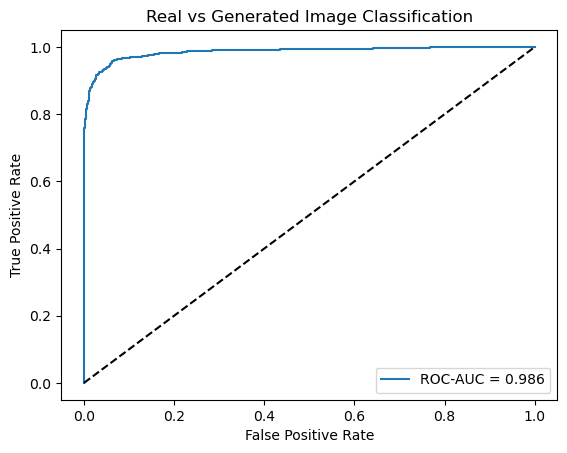

Final ROC-AUC Score: 0.986


In [ ]:
# Prepare and split data
X, y = ... # YOU CODE HERE
X_train, X_val, y_train, y_val = ... # YOU CODE HERE

# Train and evaluate
discriminator = ... # YOU CODE HERE
roc_score = ... # YOU CODE HERE
print(f"Final ROC-AUC Score: {roc_score:.3f}")

**Observations:** YOUR OBSERVATIONS HERE.

### 1.8 Plot Reconstructions (1 point)

The *reconstruction* process follows these steps:
1. Take an input $x$ from the dataset
2. Encode it using the encoder model ${\color{red}q_\phi}(z|x)$
3. Sample from this distribution via the reparameterization trick
4. Decode the sample using ${\color{blue}p_\theta}(x|z)$

The resulting generated image is called a *reconstruction*, which should be similar to the original input $x$.

In [ ]:
def plot_reconstructions(
    loss_vae: Callable[[torch.Tensor, nn.Module, nn.Module], tuple[torch.Tensor, torch.Tensor]],
    encoder: nn.Module,
    decoder: nn.Module,
    test_dataset: torch.utils.data.Dataset,
    logits_to_pixels: Callable[[torch.Tensor], torch.Tensor],
    data_dim: int = DATA_DIM,
    img_shape: tuple[int, int] = (28, 28),
    n_rows: int = 5,
    n_cols: int = 10,
    figsize_scale: float = 1.4,
    device: torch.device = DEVICE,
) -> None:
    """
    Visualize original images and their VAE reconstructions side-by-side.

    Args:
        loss_vae: VAE loss function that returns (loss, reconstructions)
        encoder: Trained encoder network (qϕ(z|x))
        decoder: Trained decoder network (pθ(x|z))
        test_dataset: Dataset containing test images
        logits_to_pixels: Function converting output of decoder to pixels
        data_dim: Dimension of flattened input data
        img_shape: Shape of output images (height, width)
        n_rows: Number of rows in grid
        n_cols: Number of columns in grid (must be even)
        figsize_scale: Scaling factor for figure size
        device: Device to run computations on
    """
    n_samples = n_rows * (n_cols // 2)  # Each sample takes 2 columns

    with torch.no_grad():
        batch = test_dataset.data[:n_samples].float() / 255.0
        batch = batch.view(-1, data_dim).to(device)

        reconstructions = ... # YOU CODE HERE

        originals = batch.view(-1, *img_shape).cpu().numpy()
        reconstructions = reconstructions.view(-1, *img_shape).cpu().numpy()

    _, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(int(figsize_scale * n_cols), int(figsize_scale * n_rows)),
        subplot_kw={"xticks": [], "yticks": []},
    )

    for i in range(n_samples):
        row = i % n_rows
        col_original = 2 * (i // n_rows)
        col_recon = col_original + 1

        axes[row, col_original].imshow(originals[i], cmap="gray", vmin=0, vmax=1)
        axes[row, col_recon].imshow(reconstructions[i], cmap="gray", vmin=0, vmax=1)

        if row == 0:
            axes[row, col_original].set_title("Original")
            axes[row, col_recon].set_title("Reconstruction")

    plt.tight_layout()
    plt.show()

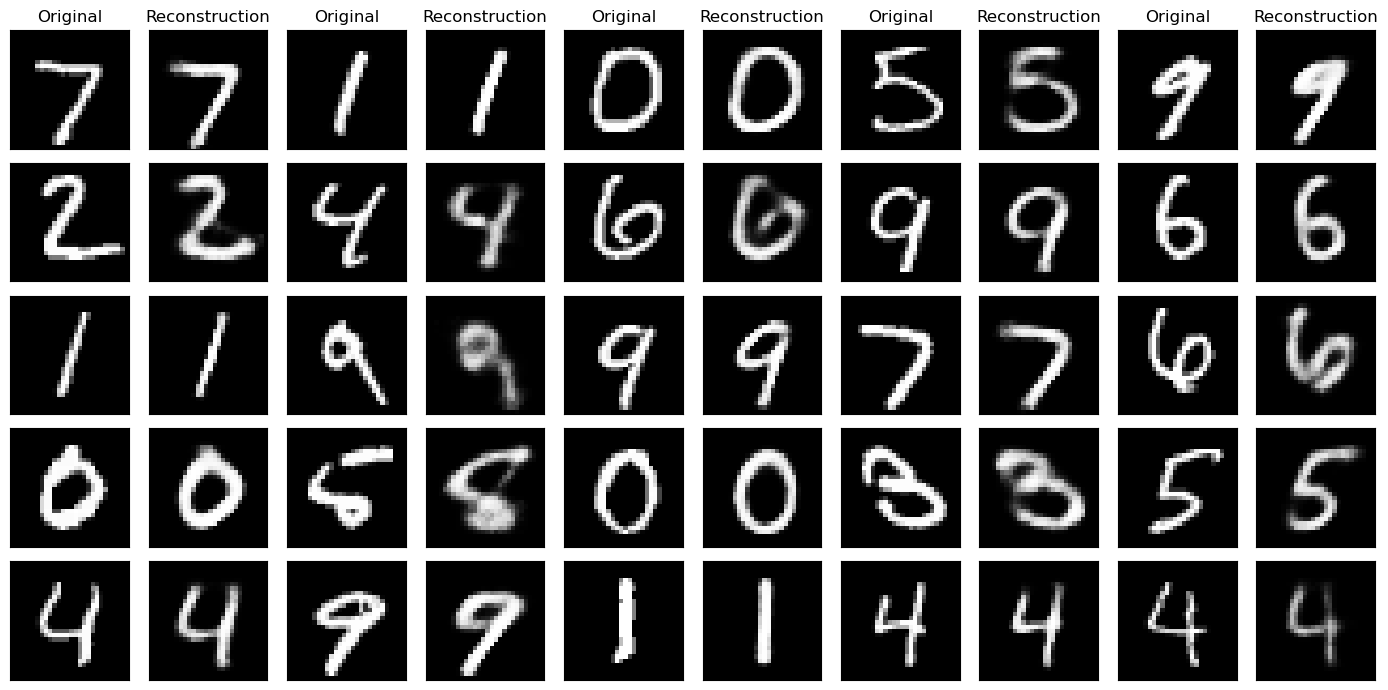

In [29]:
plot_reconstructions(
    loss_vae_bernoulli, encoder_bernoulli, decoder_bernoulli, test_dataset, logits_to_pixels_bernoulli
)

### 1.9 Understanding Latent Space Through Interpolation (1 point)

The first approach to explore a VAE's latent space is through **interpolation**. We:

1. Select two latent codes ${\color{purple}z_0}$ and ${\color{purple}z_1}$
2. Construct a straight line between them in latent space
3. Decode samples at points along this line

The resulting sequence shows how the decoder transforms gradual changes in latent space to meaningful variations in data space.

In [ ]:
def plot_interpolations(
    encoder: nn.Module,
    decoder: nn.Module,
    test_dataset: torch.utils.data.Dataset,
    logits_to_pixels: Callable[[torch.Tensor], torch.Tensor],
    latent_dim: int = LATENT_DIM,
    data_dim: int = DATA_DIM,
    n_pairs: int = 5,
    n_steps: int = 10,
    img_shape: tuple[int, int] = (28, 28),
    figsize: tuple[int, int] = (14, 7),
    device: torch.device = DEVICE,
) -> None:
    """
    Visualize linear interpolations between latent vectors of test images.

    Args:
        encoder: Trained encoder network (qϕ(z|x))
        decoder: Trained decoder network (pθ(x|z))
        test_dataset: Dataset containing test images
        logits_to_pixels: Function converting decoder outputs to pixel values
        latent_dim: Dimension of latent space
        data_dim: Dimension of flattened input data
        n_pairs: Number of image pairs to interpolate between
        n_steps: Number of interpolation steps
        img_shape: Shape of output images (height, width)
        figsize: Size of the output figure
        device: Device to run computations on
    """
    with torch.no_grad():
        # Get test images and normalize
        batch = test_dataset.data[:2 * n_pairs].float() / 255.0  # Normalize to [0,1]
        batch = batch.view(-1, data_dim).to(device)
        
        # Encode to latent space
        ... # YOU CODE HERE
        
        # Sample using reparameterization trick
        ... # YOU CODE HERE

        # Prepare endpoint pairs
        z_start = ... # YOU CODE HERE
        z_end = ... # YOU CODE HERE

        # Linear interpolation
        alpha = ... # YOU CODE HERE
        interpolations_z = ... # YOU CODE HERE
        interpolations_z = ... # YOU CODE HERE

        # Decode and convert to pixel values
        decoded = ... # YOU CODE HERE
        interpolations_x = ... # YOU CODE HERE
        interpolations_x = interpolations_x.view(n_pairs, n_steps, *img_shape).cpu().numpy()

    # Plotting
    _, axes = plt.subplots(n_pairs, n_steps, figsize=figsize, 
                           subplot_kw={'xticks': [], 'yticks': []})
    
    for i in range(n_pairs):
        for j in range(n_steps):
            axes[i,j].imshow(interpolations_x[i,j], cmap='gray')
            
    plt.tight_layout()
    plt.show()

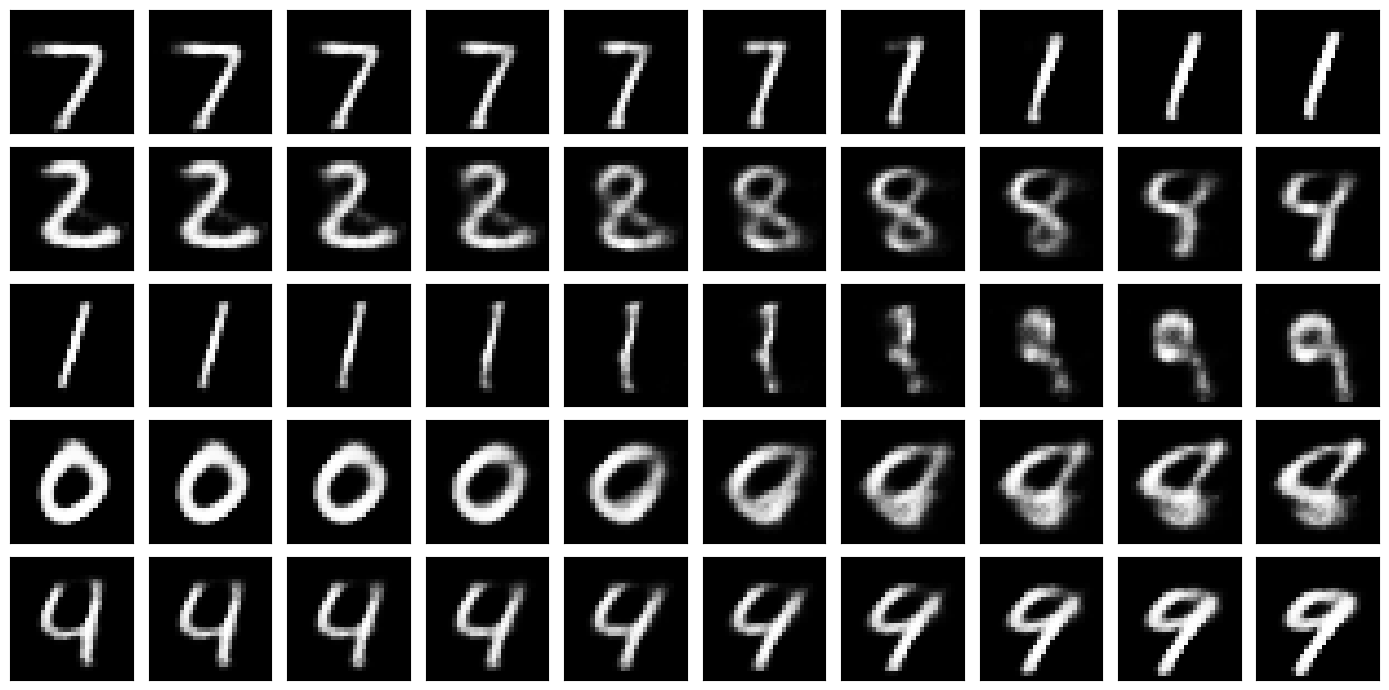

In [35]:
plot_interpolations(encoder_bernoulli, decoder_bernoulli, test_dataset, logits_to_pixels_bernoulli)

### 1.10 Latent Space Visualization

The latent space structure can be analyzed using geometric machine learning methods, particularly [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

In [36]:
from sklearn.manifold import TSNE

In [48]:
def plot_latent_tsne(
    encoder: nn.Module,
    test_dataset: torch.utils.data.Dataset,
    n_samples: int = 1000,
    data_dim: int = DATA_DIM,
    device: torch.device = DEVICE,
    figsize: tuple[int, int] = (8, 8),
    random_state: int = 42,
) -> None:
    """
    Visualize latent space using t-SNE dimensionality reduction.

    Args:
        encoder: Trained encoder network (qϕ(z|x))
        test_dataset: Dataset with test images and labels
        n_samples: Number of samples to visualize (max: len(test_dataset))
        latent_dim: Dimension of latent space
        data_dim: Dimension of flattened input data
        device: Device to run computations on
        figsize: Size of the output figure
        random_state: Random seed for t-SNE reproducibility
    """
    # Get latent representations
    with torch.no_grad():
        n_samples = min(n_samples, len(test_dataset))
        batch = test_dataset.data[:n_samples].float() / 255.0
        batch = batch.view(-1, data_dim).to(device)
        mu, _ = encoder(batch)  # Only need mean for visualization
        mu = mu.cpu().numpy()
        labels = test_dataset.targets[:n_samples].numpy()

    # Compute t-SNE embeddings
    tsne = TSNE(n_components=2, random_state=random_state)
    tsne_embeddings = tsne.fit_transform(mu)

    plt.figure(figsize=figsize)
    for class_idx in np.unique(labels):
        mask = labels == class_idx
        plt.scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1], label=str(class_idx), alpha=0.6, s=15)

    plt.legend(title="Digit Class", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.title("t-SNE Visualization of VAE Latent Space")
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

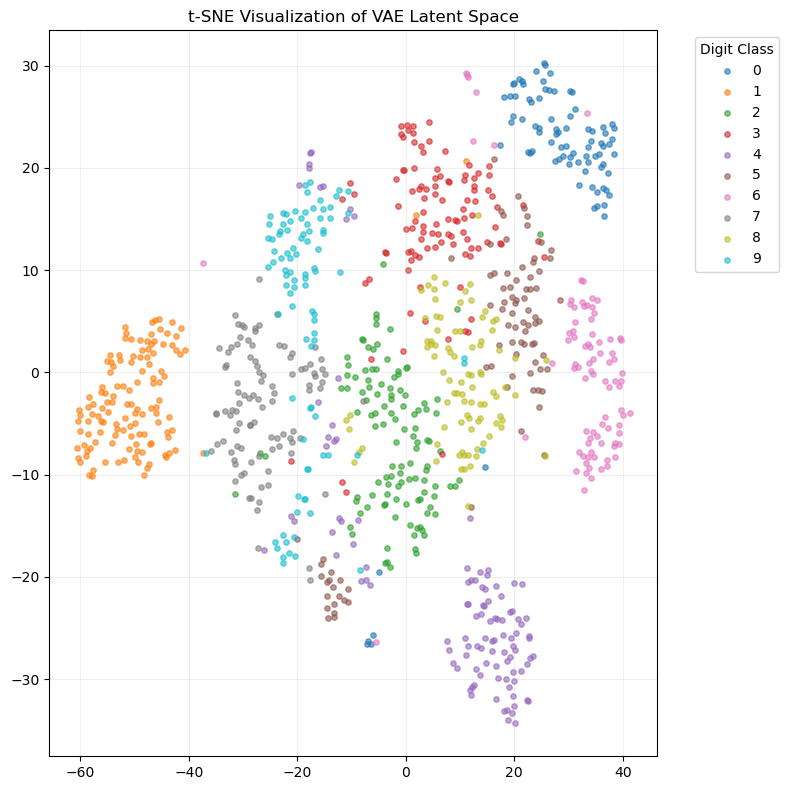

In [49]:
plot_latent_tsne(encoder_bernoulli, test_dataset)

## Task 2. VAE with Categorical Decoder (5 points)

**Decoder Modification Task** (3 pts)

1. **Modification Required**:
   - Replace the Bernoulli decoder ${\color{blue}p_\theta}(x|z)$ with a **Categorical decoder** for 8 gray-level features (8 color gradations)

2. **Training**:
   - Retrain your VAE with the new decoder

3. **Evaluation**:
   - Compare classifier ROC-AUC scores between:
     - Real images vs Bernoulli decoder (2 features)
     - Real images vs Categorical decoder (8 features)

**Note**: The Categorical distribution models discrete outcomes with multiple categories. [Learn more](https://en.wikipedia.org/wiki/Categorical_distribution).

In [51]:
NUM_CATEGORIES = 8

In [ ]:
class CategoricalDecoder(nn.Module):
    def __init__(
        self,
        data_dim: int = DATA_DIM,
        latent_dim: int = LATENT_DIM,
        hidden_dim: int = HIDDEN_DIM,
        num_categories: int = NUM_CATEGORIES,
    ):
        super(CategoricalDecoder, self).__init__()
        self.net = nn.Sequential(
            ... # YOU CODE HERE
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return ... # YOU CODE HERE # outputs logits for Categorical distribution

In [ ]:
def preprocess_x_categorical(x: torch.Tensor, num_categories: int = NUM_CATEGORIES) -> torch.Tensor:
    """
    Preprocess input tensor for categorical likelihood by mapping continuous values 
    in [0, 1] to discrete category indices in [0, num_categories - 1].

    Args:
        x: Input tensor with values in [0, 1] of shape [batch_size, data_dim]
        num_categories: Number of discrete output categories (default: NUM_CATEGORIES)

    Returns:
        Tensor of integer indices in [0, num_categories - 1]
    """
    return ... # YOU CODE HERE

In [ ]:
def px_z_categorical(logits: torch.Tensor) -> torch.distributions.Distribution:
    """
    Define the likelihood distribution p(x|z) using a Categorical distribution
    for each of the D discrete dimensions.

    Args:
        logits: Output from the decoder of shape [B, D, C],
                where each [D, C] slice defines Categorical logits

    Returns:
        An Independent distribution over D Categorical distributions
    """
    return ... # YOU CODE HERE

In [ ]:
def logits_to_pixels_categorical(logits: torch.Tensor, num_categories: int = NUM_CATEGORIES) -> torch.Tensor:
    """
    Convert decoder logits to pixel values of the most probable class from the Categorical distribution.
    
    Args:
        logits: Unbounded output tensor from the decoder network
               Shape: [B, D, C]
        num_categories: Number of possible categories (C) for normalization
               
    Returns:
        Tensor of sampled pixel values in range [0, 1] with shape [B, D].
    """
    return ... # YOU CODE HERE

In [109]:
loss_vae_categorical = partial(
    loss_vae,
    preprocess_x=preprocess_x_categorical,
    px_z=px_z_categorical,
)

In [ ]:
# Choose appropriate hyper-parameters
BATCH_SIZE = ... # YOU CODE HERE
NUM_EPOCHS = ... # YOU CODE HERE
LR = ... # YOU CODE HERE

In [ ]:
encoder_categorical = # YOU CODE HERE
decoder_categorical = # YOU CODE HERE

In [ ]:
train_losses, val_losses = train_model(
    loss_fn=loss_vae_categorical,
    encoder=encoder_categorical,
    decoder=decoder_categorical,
    train_dataset=train_dataset,
    test_dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    learning_rate=LR,
)

In [ ]:
visualize_samples(generate_vae_samples(decoder=decoder_categorical, logits_to_pixels=logits_to_pixels_categorical))

In [ ]:
# Prepare and split data
X, y = ... # YOU CODE HERE
X_train, X_val, y_train, y_val = ... # YOU CODE HERE

# Train and evaluate
discriminator = ... # YOU CODE HERE
roc_score = ... # YOU CODE HERE
print(f"Final ROC-AUC Score: {roc_score:.3f}")

**Observations:** YOUR OBSERVATIONS HERE.